NVM (this file only compares the protein counts, the comparison with HLs will be done later) - SO in this file I will be comparing the half life values of proteins between the Nagar et al. data and Gupta et al. data to see if there are any stark contrast differences between trends in measurements for proteins known to interact with metals and those that do not. 



This file compares the protein counts between CLClim3NE and the schmidt validation data (where the two overlap). the metal interactions that take place between monomers are highlighted (not sure if the fact that these proteins might also interact with compelxes is needed). 

In [16]:
import pandas as pd
import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import os 
os.chdir(os.path.expanduser('~/wcEcoli'))

In [3]:
# load in data frame that lists protein + metal ion interations:
protein_metal_data = pd.read_csv("models/ecoli/analysis/local_notebooks/data/metal_comparisons/metal_protein_interaction_df.csv")
protein_metal_data

# todo: note this data has way more proteins than the comparison data has because it also includes the complex interactions. I am not sure if the fact that there are single proteins on here means that they also have their own separate interactions with metals in addition or inteacting with them as cofactors in complexes or if this is also just accounting for how they are just part of complexes known to interact with cofactors (but I think this would then be double counting almost?).

,FE,ZN,MN,CU,MO,NI,CO,Protein ID
0,0,0,0,0,0,0,0,1-PFK
1,0,0,0,0,0,0,0,2OXOGLUTARATEDEH-CPLX
2,0,0,0,0,0,0,0,3-ISOPROPYLMALDEHYDROG-CPLX
3,4,0,0,0,0,0,0,3-ISOPROPYLMALISOM-CPLX
4,0,0,0,0,0,0,0,3-METHYL-2-OXOBUT-OHCH3XFER-CPLX
...,...,...,...,...,...,...,...,...
5522,0,0,0,0,0,0,0,YTFR-MONOMER
5523,0,0,0,0,0,0,0,YTFT-MONOMER
5524,0,1,0,0,0,0,0,ZNUA-MONOMER
5525,0,0,0,0,0,0,0,ZNUB-MONOMER


In [ ]:
# todo: define a comparison data set (with a Protein ID column, Sim counts column, and Validation data column) like the ones created with the save protein counts data columns. Get the log versions too 

In [5]:
# here is some initial data to work with that has the sim protein counts data and the validation data:
log_data = pd.read_csv("models/ecoli/analysis/local_notebooks/metal_comparisons/data/Log10_Schmidt_Comparison_startGen_2_CLClim3NE.csv") 
log_data

,Monomer ID,Log10 Simulated Counts,Log10 Schmidt Validation Counts
0,EG10460-MONOMER[c],2.170935,1.301030
1,G7458-MONOMER[p],1.928810,0.000000
2,G7031-MONOMER[c],1.540384,2.416641
3,PD00197[c],3.496334,2.785330
4,G7211-MONOMER[c],2.755937,1.792392
...,...,...,...
2136,EG11305-MONOMER[i],2.765680,1.662758
2137,EG10919-MONOMER[c],4.425160,4.460055
2138,G7395-MONOMER[c],2.837331,3.269046
2139,HISTDEHYD-MONOMER[c],2.780608,3.537567


In [10]:
# manipulate the data to match the form below

# change the Monomer ID column to say Protein ID: 
log_data = log_data.rename(columns={"Monomer ID": "Protein ID"})

# remove the last three characters of each protein ID to match the format of the protein_metal_data dataframe:
log_data["Protein ID"] = log_data["Protein ID"].str[:-3]


In [11]:
# DETERMINE WHICH PROTEINS HAVE METAL INTERACTIONS

# determine which proteins in the comparison data have metal interactions and which do not:
interaction_df = pl.DataFrame(protein_metal_data[["Protein ID", "FE", "ZN", "MN", "CU", "MO", "NI", "CO"]])

# find the proteins that are cross listed between the comparison data and the metal interaction data:
def find_cross_listed_proteins(interaction_df, comparison_df):
	# Filter out proteins with metal interactions:
	cross_listed_df = pl.DataFrame(comparison_df).join(interaction_df, how="inner", on="Protein ID")
	cross_listed_df = cross_listed_df.drop(["Log10 Simulated Counts", "Log10 Schmidt Validation Counts"])
	return cross_listed_df

# find the proteins that are in the dataset and have metal interactions: 
cross_listed_df = find_cross_listed_proteins(interaction_df, log_data)

# Define the columns of interest
metal_columns = ['FE', 'ZN', 'MN', 'CU', 'MO', 'NI', 'CO']

# Add a new column that counts the nonzero values for each Protein ID across the metal columns
cross_listed_df_with_counts = cross_listed_df.with_columns(
    (pl.sum_horizontal([pl.col(col) != 0 for col in metal_columns])).alias("nonzero_count"))
cross_listed_df_with_counts # output should be around 2141 in length

Protein ID,FE,ZN,MN,CU,MO,NI,CO,nonzero_count
str,i64,i64,i64,i64,i64,i64,i64,u32
"""1-ACYLGLYCEROL-3-P-ACYLTRANSFE…",0,0,0,0,0,0,0,0
"""1-PFK-MONOMER""",0,0,0,0,0,0,0,0
"""2-DEHYDROPANTOATE-REDUCT-MONOM…",0,0,0,0,0,0,0,0
"""2-ISOPROPYLMALATESYN-MONOMER""",0,0,0,0,0,0,0,0
"""2-OCTAPRENYL-METHOXY-BENZOQ-ME…",0,0,0,0,0,0,0,0
…,…,…,…,…,…,…,…,…
"""YRBF-MONOMER""",0,0,0,0,0,0,0,0
"""YTFQ-MONOMER""",0,0,0,0,0,0,0,0
"""YTFR-MONOMER""",0,0,0,0,0,0,0,0


In [ ]:
# todo: consider doing this with the other validation dataset 

## Plot #1) Proteins with Metal Interactions

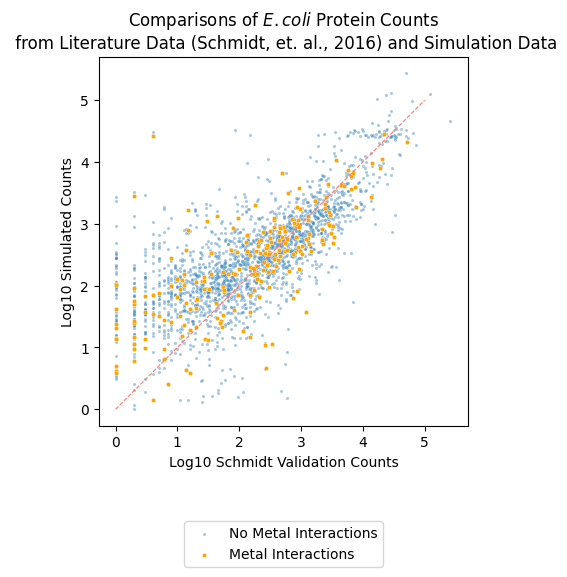

In [29]:
# find proteins that have at least one interaction: 
proteins_with_interactions = cross_listed_df_with_counts.filter(pl.col("nonzero_count") > 0)

# change log_data to a pl df: 
log_data = pl.DataFrame(log_data)
proteins_with_interactions = proteins_with_interactions.join(log_data, how="inner", on="Protein ID")

# find proteins with no interactions:
no_interactions_df = cross_listed_df.filter(~pl.col("Protein ID").is_in(proteins_with_interactions["Protein ID"]))
no_interactions_df = no_interactions_df.join(log_data, how="inner", on="Protein ID")

# plot the comparison graph with proteins that have metal interactions in red and proteins that do not have metal interactions in blue:
sns.scatterplot(y="Log10 Simulated Counts", x="Log10 Schmidt Validation Counts", data=no_interactions_df.to_pandas(), s=5, alpha=.4)
sns.scatterplot(y="Log10 Simulated Counts", x="Log10 Schmidt Validation Counts", data=proteins_with_interactions.to_pandas(), s=10, color="orange")
# find the max value of the plot for making a y=x line: 
max_vals = [max(log_data["Log10 Simulated Counts"]), max(log_data["Log10 Schmidt Validation Counts"])]; max_val = round(max(max_vals))
yxvals = range(0, max_val + 1) 
plt.plot(yxvals, yxvals, linewidth=.8, linestyle="dashed", color="#FF796C"); 

# plot specs
plt.axis('square')
plt.title("Comparisons of $\t{E. coli}$ Protein Counts from Literature \nData (Schmidt et al., 2016) and Simulation Data")
plt.legend(["No Metal Interactions", "Metal Interactions"], bbox_to_anchor=(.5, -.4), loc='lower center')

## Plot #2) Proteins with Metal Interactions (by number of interactions)


In [26]:
# reaname for simplicity: 
rm_comparison_df = log_data

In [27]:
# find the max number of interactions a protein has:
max_interactions = max(cross_listed_df_with_counts["nonzero_count"])
max_interactions

2

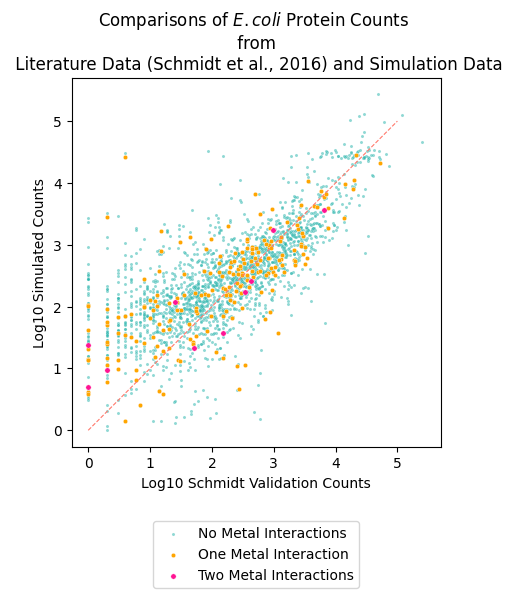

In [35]:
# already have dataframe for proteins with no interactions, but find the rest: 
one_interaction = cross_listed_df_with_counts.filter(pl.col("nonzero_count") == 1) # gives 525 rows
one_interaction = one_interaction.join(rm_comparison_df, how="inner", on="Protein ID")
two_interactions = cross_listed_df_with_counts.filter(pl.col("nonzero_count") == 2) # gives 40 rows
two_interactions = two_interactions.join(rm_comparison_df, how="inner", on="Protein ID")

# plot the comparison graph with proteins that have metal interactions in red and proteins that do not have metal interactions in blue:
sns.scatterplot(y="Log10 Simulated Counts", x="Log10 Schmidt Validation Counts", data=no_interactions_df.to_pandas(), s=5, color='lightseagreen', alpha=.5)
sns.scatterplot(y="Log10 Simulated Counts", x="Log10 Schmidt Validation Counts", data=one_interaction.to_pandas(), s=10, color="orange")
sns.scatterplot(y="Log10 Simulated Counts", x="Log10 Schmidt Validation Counts", data=two_interactions.to_pandas(), s=15, color="deeppink")

# find the max value of the plot for making a y=x line: 
max_vals = [max(rm_comparison_df["Log10 Simulated Counts"]), max(rm_comparison_df["Log10 Schmidt Validation Counts"])]; max_val = round(max(max_vals))
yxvals = range(0, max_val + 1) 
plt.plot(yxvals, yxvals, linewidth=.8, linestyle="dashed", color="#FF796C"); 

# plot specs
plt.axis('square')
plt.title("Comparisons of $\t{E. coli}$ Protein Counts  \n from \n Literature Data (Schmidt et al., 2016) and Simulation Data")
plt.legend(["No Metal Interactions", "One Metal Interaction", "Two Metal Interactions"], bbox_to_anchor=(.5, -.4), loc='lower center')

## Plot #3) Proteins with Metal Interactions (by metal type)


In [36]:
# FUNCTIONS

# find the proteins that have Iron (Fe) interactions:
def find_Fe_interactions(interaction_df):
	Fe_filtered = interaction_df.filter(pl.col("FE") > 0)
	Fe_df = Fe_filtered.select(pl.col(["Protein ID", "FE"]))
	return Fe_df

# find the proteins that have Zinc (Zn) interactions:
def find_Zn_interactions(interaction_df):
	Zn_filtered = interaction_df.filter(pl.col("ZN") > 0)
	Zn_df = Zn_filtered.select(pl.col(["Protein ID", "ZN"]))
	return Zn_df

# find the proteins that have Manganese (Mn) interactions:
def find_Mn_interactions(interaction_df):
	Mn_filtered = interaction_df.filter(pl.col("MN") > 0)
	Mn_df = Mn_filtered.select(pl.col(["Protein ID", "MN"]))
	return Mn_df

# find the proteins that have Copper (Cu) interactions:
def find_Cu_interactions(interaction_df):
	Cu_filtered = interaction_df.filter(pl.col("CU") > 0)
	Cu_df = Cu_filtered.select(pl.col(["Protein ID", "CU"]))
	return Cu_df

# find the proteins that have Molybdenum (Mo) interactions:
def find_Mo_interactions(interaction_df):
	Mo_filtered = interaction_df.filter(pl.col("MO") > 0)
	Mo_df = Mo_filtered.select(pl.col(["Protein ID", "MO"]))
	return Mo_df

# find the proteins that have Nickel (Ni) interactions:
def find_Ni_interactions(interaction_df):
	Ni_filtered = interaction_df.filter(pl.col("NI") > 0)
	Ni_df = Ni_filtered.select(pl.col(["Protein ID", "NI"]))
	return Ni_df

# find the proteins that have Cobalt (Co) interactions:
def find_Co_interactions(interaction_df):
	Co_filtered = interaction_df.filter(pl.col("CO") > 0)
	Co_df = Co_filtered.select(pl.col(["Protein ID", "CO"]))
	return Co_df


In [37]:
# find the metal interaction for the proteins with just one interaction: 
Fe_df = find_Fe_interactions(one_interaction); Fe_df = Fe_df.join(rm_comparison_df, how="inner", on="Protein ID")
Zn_df = find_Zn_interactions(one_interaction); Zn_df = Zn_df.join(rm_comparison_df, how="inner", on="Protein ID")
Mn_df = find_Mn_interactions(one_interaction); Mn_df = Mn_df.join(rm_comparison_df, how="inner", on="Protein ID")
Cu_df = find_Cu_interactions(one_interaction); Cu_df = Cu_df.join(rm_comparison_df, how="inner", on="Protein ID")
Mo_df = find_Mo_interactions(one_interaction); Mo_df = Mo_df.join(rm_comparison_df, how="inner", on="Protein ID")
Ni_df = find_Ni_interactions(one_interaction); Ni_df = Ni_df.join(rm_comparison_df, how="inner", on="Protein ID")
Co_df = find_Co_interactions(one_interaction); Co_df = Co_df.join(rm_comparison_df, how="inner", on="Protein ID")

# find the metal interaction for the proteins with two interactions:
Fe_df2 = find_Fe_interactions(two_interactions)
Zn_df2 = find_Zn_interactions(two_interactions)
Mn_df2 = find_Mn_interactions(two_interactions)
Cu_df2 = find_Cu_interactions(two_interactions)
Mo_df2 = find_Mo_interactions(two_interactions)
Ni_df2 = find_Ni_interactions(two_interactions)
Co_df2 = find_Co_interactions(two_interactions)

# figure out which proteins have two interactions and sort them (since each only has 2 max, this should be not too difficult):
def remove_proteins(dfs, proteins_to_remove):
	for df in dfs:
		for protein_id in proteins_to_remove:
			df = df.filter(pl.col("Protein ID") != protein_id)
	

df2_list = [Fe_df2, Zn_df2, Mn_df2, Cu_df2, Mo_df2, Ni_df2, Co_df2]

# find proteins that have a match between the Fe and Zn Dataframes:
Fe_Zn_df = Fe_df2.join(Zn_df2, how="inner", on="Protein ID"); 
remove_proteins(df2_list, Fe_Zn_df["Protein ID"])

# find proteins that have a match between the Fe and Mn Dataframes:
Fe_Mn_df = Fe_df2.join(Mn_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Fe_Mn_df["Protein ID"])

# find proteins that have a match between the Fe and Cu Dataframes:
Fe_Cu_df = Fe_df2.join(Cu_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Fe_Cu_df["Protein ID"])

# find proteins that have a match between the Fe and Mo Dataframes:
Fe_Mo_df = Fe_df2.join(Mo_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Fe_Mo_df["Protein ID"])

# find proteins that have a match between the Fe and Ni Dataframes:
Fe_Ni_df = Fe_df2.join(Ni_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Fe_Ni_df["Protein ID"])

# find proteins that have a match between the Fe and Co Dataframes:
Fe_Co_df = Fe_df2.join(Co_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Fe_Co_df["Protein ID"])

# find proteins that have a match between the Zn and Mn Dataframes:
Zn_Mn_df = Zn_df2.join(Mn_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Zn_Mn_df["Protein ID"])

# find proteins that have a match between the Zn and Cu Dataframes:
Zn_Cu_df = Zn_df2.join(Cu_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Zn_Cu_df["Protein ID"])

# find proteins that have a match between the Zn and Mo Dataframes:
Zn_Mo_df = Zn_df2.join(Mo_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Zn_Mo_df["Protein ID"])

# find proteins that have a match between the Zn and Ni Dataframes:
Zn_Ni_df = Zn_df2.join(Ni_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Zn_Ni_df["Protein ID"])

# find proteins that have a match between the Zn and Co Dataframes:
Zn_Co_df = Zn_df2.join(Co_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Zn_Co_df["Protein ID"])

# find proteins that have a match between the Mn and Cu Dataframes:
Mn_Cu_df = Mn_df2.join(Cu_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Mn_Cu_df["Protein ID"])

# find proteins that have a match between the Mn and Mo Dataframes:
Mn_Mo_df = Mn_df2.join(Mo_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Mn_Mo_df["Protein ID"])

# find proteins that have a match between the Mn and Ni Dataframes:
Mn_Ni_df = Mn_df2.join(Ni_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Mn_Ni_df["Protein ID"])

# find proteins that have a match between the Mn and Co Dataframes:
Mn_Co_df = Mn_df2.join(Co_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Mn_Co_df["Protein ID"])
	
# find proteins that have a match between the Cu and Mo Dataframes:
Cu_Mo_df = Cu_df2.join(Mo_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Cu_Mo_df["Protein ID"])
	
# find proteins that have a match between the Cu and Ni Dataframes:
Cu_Ni_df = Cu_df2.join(Ni_df2, how="inner", on="Protein ID");

# find proteins that have a match between the Cu and Co Dataframes:
Cu_Co_df = Cu_df2.join(Co_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Cu_Co_df["Protein ID"])

# find proteins that have a match between the Mo and Ni Dataframes:
Mo_Ni_df = Mo_df2.join(Ni_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Mo_Ni_df["Protein ID"])

# find proteins that have a match between the Mo and Co Dataframes:
Mo_Co_df = Mo_df2.join(Co_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Mo_Co_df["Protein ID"])

# find proteins that have a match between the Ni and Co Dataframes:
Ni_Co_df = Ni_df2.join(Co_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Ni_Co_df["Protein ID"])
	
# find proteins that have a match between the Ni and Co Dataframes:
Ni_Co_df = Ni_df2.join(Co_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Ni_Co_df["Protein ID"])

# find the proteins that have more than one metal interaction:
check = Fe_df2.join(Zn_df2, how="inner", on="Protein ID")
check = check.join(Mn_df2, how="inner", on="Protein ID")
check = check.join(Cu_df2, how="inner", on="Protein ID")
check = check.join(Mo_df2, how="inner", on="Protein ID")
check = check.join(Ni_df2, how="inner", on="Protein ID")
check = check.join(Co_df2, how="inner", on="Protein ID")
check # should be empty

Protein ID,FE,ZN,MN,CU,MO,NI,CO
str,i64,i64,i64,i64,i64,i64,i64


In [38]:
# find which have nonzero values: 
print(np.shape(Fe_Zn_df), np.shape(Fe_Mn_df), np.shape(Fe_Cu_df), np.shape(Fe_Mo_df), np.shape(Fe_Ni_df), np.shape(Fe_Co_df))
print(np.shape(Zn_Mn_df), np.shape(Zn_Cu_df), np.shape(Zn_Mo_df), np.shape(Zn_Ni_df), np.shape(Zn_Co_df))
print(np.shape(Mn_Cu_df), np.shape(Mn_Mo_df), np.shape(Mn_Ni_df), np.shape(Mn_Co_df))
print(np.shape(Cu_Mo_df), np.shape(Cu_Ni_df), np.shape(Cu_Co_df))
print(np.shape(Mo_Ni_df), np.shape(Mo_Co_df))
print(np.shape(Ni_Co_df))


(2, 3) (0, 3) (1, 3) (3, 3) (0, 3) (0, 3)
(1, 3) (1, 3) (0, 3) (1, 3) (1, 3)
(0, 3) (0, 3) (0, 3) (0, 3)
(0, 3) (0, 3) (0, 3)
(0, 3) (0, 3)
(0, 3)


In [39]:
df_list = []
df_combos = []
for protein in two_interactions["Protein ID"]:
	name_options = [ "FE", "ZN", "MN", "CU", "MO", "NI", "CO"]
	protein_row = two_interactions.filter(pl.col("Protein ID") == protein)
	Fe_val = protein_row["FE"].to_numpy()[0]
	Zn_val = protein_row["ZN"].to_numpy()[0]
	Mn_val = protein_row["MN"].to_numpy()[0]
	Cu_val = protein_row["CU"].to_numpy()[0]
	Mo_val = protein_row["MO"].to_numpy()[0]
	Ni_val = protein_row["NI"].to_numpy()[0]
	Co_val = protein_row["CO"].to_numpy()[0]
	values = [Fe_val, Zn_val, Mn_val, Cu_val, Mo_val, Ni_val, Co_val]
	values_idx = np.nonzero(values)
	df_names = [name_options[i] for i in values_idx[0]]
	df_name = "_".join(df_names)
	protein_row= protein_row.with_columns(
        pl.lit(df_name).alias("Metal Interactions")) 
	if df_name not in df_combos:
		df_combos.append(df_name)
		df_list.append(protein_row)
	else: 
		df_list[df_combos.index(df_name)] = df_list[df_combos.index(df_name)].vstack(protein_row)

df_combos

['FE_MO', 'FE_ZN', 'ZN_NI', 'ZN_CO', 'ZN_MN', 'ZN_CU', 'FE_CU']

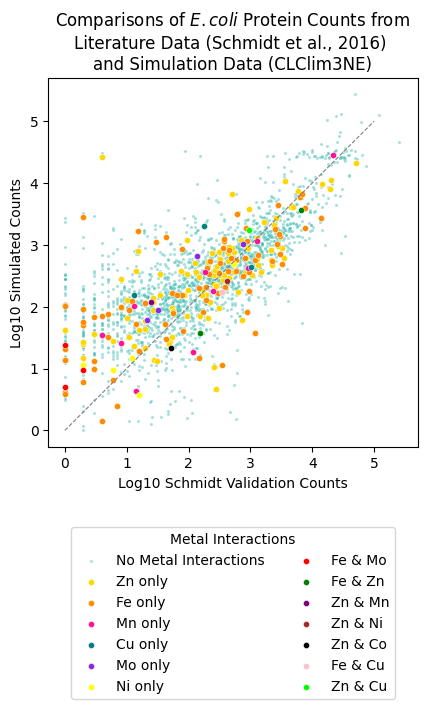

In [43]:
# plot the comparison graph with proteins that have metal interactions in red and proteins that do not have metal interactions in blue:
sns.scatterplot(y="Log10 Simulated Counts", x="Log10 Schmidt Validation Counts", data=no_interactions_df.to_pandas(), s=5, alpha=0.4, color="lightseagreen")
sns.scatterplot(y="Log10 Simulated Counts", x="Log10 Schmidt Validation Counts", data=Zn_df.to_pandas(), s=20, color="gold")
sns.scatterplot(y="Log10 Simulated Counts", x="Log10 Schmidt Validation Counts", data=Fe_df.to_pandas(), s=20, color="darkorange")
sns.scatterplot(y="Log10 Simulated Counts", x="Log10 Schmidt Validation Counts", data=Mn_df.to_pandas(), s=20, color="deeppink")
sns.scatterplot(y="Log10 Simulated Counts", x="Log10 Schmidt Validation Counts", data=Cu_df.to_pandas(), s=20, color="teal")
sns.scatterplot(y="Log10 Simulated Counts", x="Log10 Schmidt Validation Counts", data=Mo_df.to_pandas(), s=20, color="blueviolet")
sns.scatterplot(y="Log10 Simulated Counts", x="Log10 Schmidt Validation Counts", data=Ni_df.to_pandas(), s=20, color="yellow")
#sns.scatterplot(x="Sim Protein Counts", y="MOPS complete", data=Co_df.to_pandas(), s=20, color="cyan") # no Co only!
sns.scatterplot(y="Log10 Simulated Counts", x="Log10 Schmidt Validation Counts", data=df_list[0].to_pandas(), s=20, color="red")
sns.scatterplot(y="Log10 Simulated Counts", x="Log10 Schmidt Validation Counts", data=df_list[1].to_pandas(), s=20, color="green")
sns.scatterplot(y="Log10 Simulated Counts", x="Log10 Schmidt Validation Counts", data=df_list[2].to_pandas(), s=20, color="purple")
sns.scatterplot(y="Log10 Simulated Counts", x="Log10 Schmidt Validation Counts", data=df_list[3].to_pandas(), s=20, color="brown")
sns.scatterplot(y="Log10 Simulated Counts", x="Log10 Schmidt Validation Counts", data=df_list[4].to_pandas(), s=20, color="black")
sns.scatterplot(y="Log10 Simulated Counts", x="Log10 Schmidt Validation Counts", data=df_list[5].to_pandas(), s=20, color="pink")
sns.scatterplot(y="Log10 Simulated Counts", x="Log10 Schmidt Validation Counts", data=df_list[6].to_pandas(), s=20, color="lime")

# find the max value of the plot for making a y=x line: 
max_vals = [max(rm_comparison_df["Log10 Simulated Counts"]), max(rm_comparison_df["Log10 Schmidt Validation Counts"])]; max_val = round(max(max_vals))
yxvals = range(0, max_val + 1) 
plt.plot(yxvals, yxvals, linewidth=.8, linestyle="dashed", color="grey"); 

# plot specs

plt.axis('square')
plt.title("Comparisons of $\t{E. coli}$ Protein Counts from \nLiterature Data (Schmidt et al., 2016) \nand Simulation Data (CLClim3NE)")
plt.legend(["No Metal Interactions", "Zn only", "Fe only", "Mn only", "Cu only", "Mo only", "Ni only", 'Fe & Mo', 'Fe & Zn', 'Zn & Mn', 'Zn & Ni', 'Zn & Co', 'Fe & Cu', 'Zn & Cu'], title="Metal Interactions",bbox_to_anchor=(.5, -.7), loc='lower center',ncol=2)